In [7]:
pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
pip install -U cleanlab

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.5/157.5 KB 3.6 MB/s eta 0:00:00


In [12]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
import nltk
import cleanlab
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.tokenize import sent_tokenize
from seg_algorithm import get_optimal_splits, get_segmented_sentences
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
import string
from cleanlab.outlier import OutOfDistribution

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [13]:

url = "https://raw.githubusercontent.com/yahya010/DocClustering/main/Pres_Speeches/corpus.csv"
dataset = pd.read_csv(url)
p = 0.65 #increase p = no of segments decreases

stop_words = set(stopwords.words('english'))
transcripts = dataset.transcripts
tokenized_transcripts = pd.DataFrame(index=range(44), columns=['Sentences'])

fullTranscripts = []
originalTranscript_list = [] # contains 44 transcripts
transcript_list = [] #contains 44 transcripts
filteredTranscript = []

# Creates a transcript list of set number of transcripts
for transcript in transcripts[0:1]:
    transcript = sent_tokenize(transcript)
    for sentence in transcript:
      fullTranscripts.append(sentence)

# Removes stop-words
for sentence in fullTranscripts:
    words = nltk.word_tokenize(sentence)
    stop_words = set(stopwords.words('english'))
    filtered_words = [word for word in words if word.lower() not in stop_words]
    filteredTranscript.append(" ".join(filtered_words))

# Removes punctiation excluding ".", "!", "?"
exclude = string.punctuation.replace(".", "")
exclude = exclude.replace("!", "")
exclude = exclude.replace("?", "")
filteredTranscript = [s.translate(str.maketrans('', '', exclude)) for s in filteredTranscript]

# Only includes sentences with number of words greater then set value
# Cuttoff number includes end punctuation as a word
filteredTranscript = [s for s in filteredTranscript if len(s.split())>4]
print(len(filteredTranscript))

# Embedding and outlier removal
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

original_embeddings = model.encode(filteredTranscript)
ood = OutOfDistribution()
train_outlier_scores = ood.fit_score(features=original_embeddings)
top_train_outlier_idxs = (train_outlier_scores).argsort()[:10] #7 speeches, for each speech get top 20 outliers and give scores on relevance detection, novelty detection 1-5
for x in top_train_outlier_idxs:
  filteredTranscript.pop(x)
embeddings = model.encode(filteredTranscript)
#print(filteredTranscript)
print(len(filteredTranscript))
print(original_embeddings.shape)
print(embeddings.shape)
#print(top_train_outlier_idxs)


764


Fitting OOD estimator based on provided features ...
754
(764, 768)
(754, 768)


In [14]:
# Segmentation
segmentation  = get_optimal_splits(embeddings, p) # Splits.
segmented_txt = get_segmented_sentences(filteredTranscript, segmentation)
segment_list = []
for segment in segmented_txt:
    segment_list.append('Segment ' + str(segmented_txt.index(segment)) + ': ' + str(segment))

seglistDF = pd.DataFrame(segment_list)
seglistDF.to_csv('fullSegmentationList.csv')

In [15]:
def squared_sum(x):
  """ return 3 rounded square rooted value """
  return round(np.sqrt(sum([a*a for a in x])),3)

def cos_similarity(x,y):
  """ return cosine similarity between two lists """
  numerator = sum(a*b for a,b in zip(x,y))
  denominator = squared_sum(x)*squared_sum(y)
  return round(numerator/float(denominator),3)

In [16]:
# PCA-95 Dimensionality Reduction
pca = PCA(n_components=0.95)
reduced_embedding = pca.fit_transform(embeddings)
print(reduced_embedding.shape)

(754, 220)


In [17]:
pip install hdbscan umap umap-learn[plot]


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 39.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 9.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 66.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.5/76.5 KB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for hdbscan: filename=hdbscan-0.8.29-cp38-cp38-linux_x86_64.whl size=3773972 sha256=765e035c07d4d6f219953474675ac5811a66a2a8180cf90ab655876f85311789
  Stored in directory: /root/.cache/pi

In [18]:
from sklearn.datasets import fetch_openml
import umap
import hdbscan
import sklearn.cluster as cluster
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


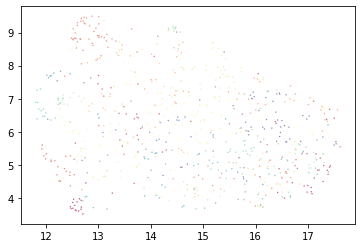

In [19]:
kmeans_labels = cluster.KMeans(n_clusters=30).fit_predict(reduced_embedding)
standard_embedding = umap.UMAP(random_state=42).fit_transform(reduced_embedding)
plt.scatter(standard_embedding[:, 0], standard_embedding[:, 1], c=kmeans_labels, s=0.1, cmap='Spectral')

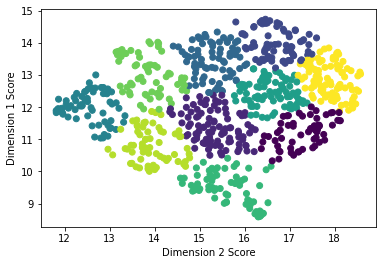

In [21]:
#Umap Clustering

reducer = umap.UMAP(n_components=2)
sentences_embeddings_reduced = reducer.fit_transform(embeddings)

# Apply KMeans clustering to the reduced embeddings
kmeans = KMeans(n_clusters=10)
kmeans.fit(sentences_embeddings_reduced)

# Get the cluster labels for each sentence
labels = kmeans.labels_
plt.scatter(sentences_embeddings_reduced[:, 0], sentences_embeddings_reduced[:, 1], c=labels)
plt.xlabel('Dimension 2 Score')
plt.ylabel('Dimension 1 Score')
plt.show()


In [22]:
pip install wordcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


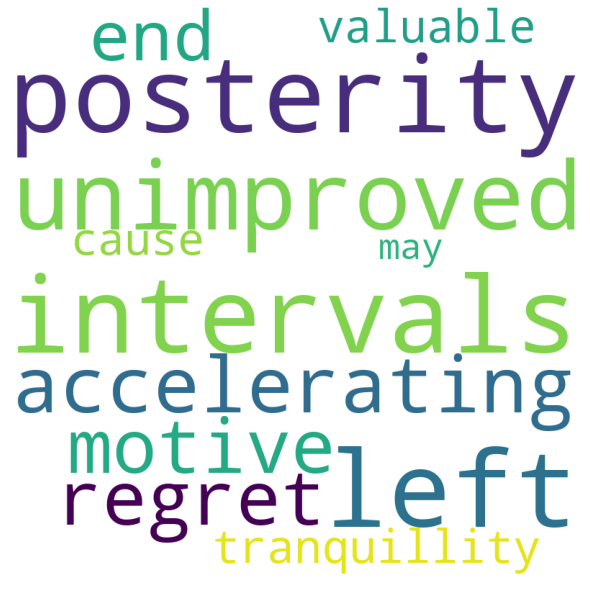

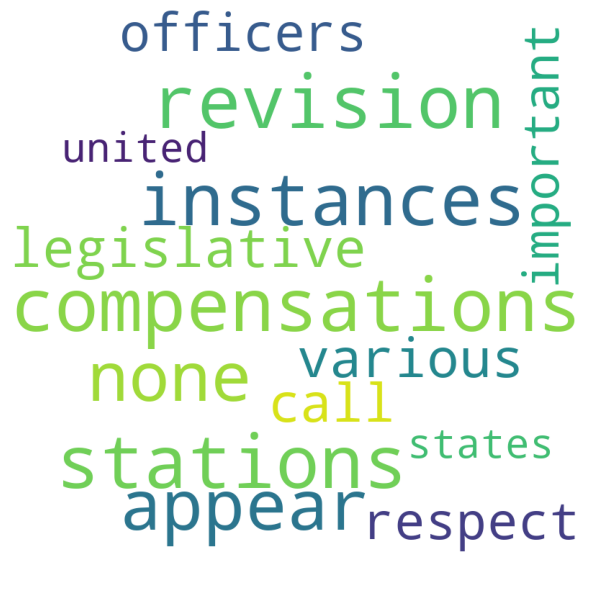

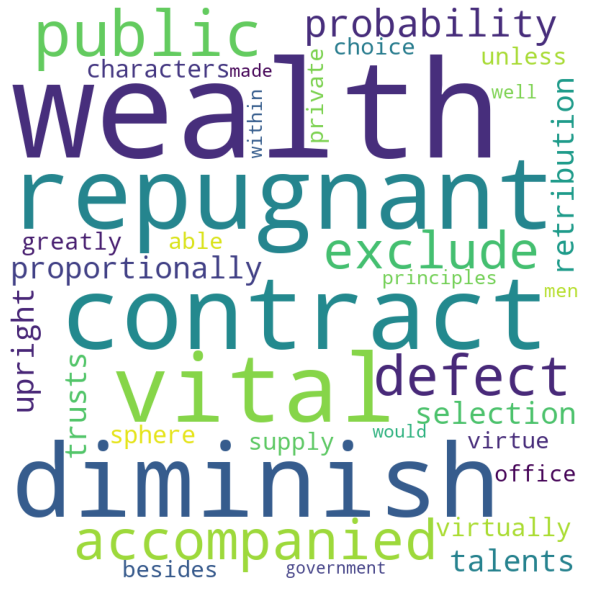

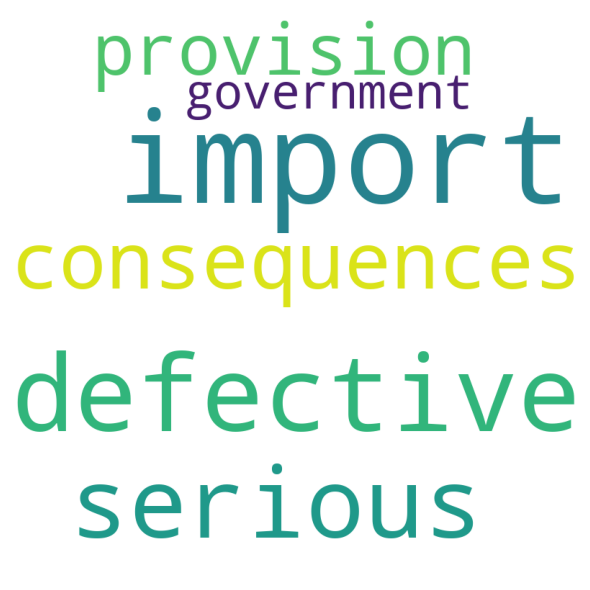

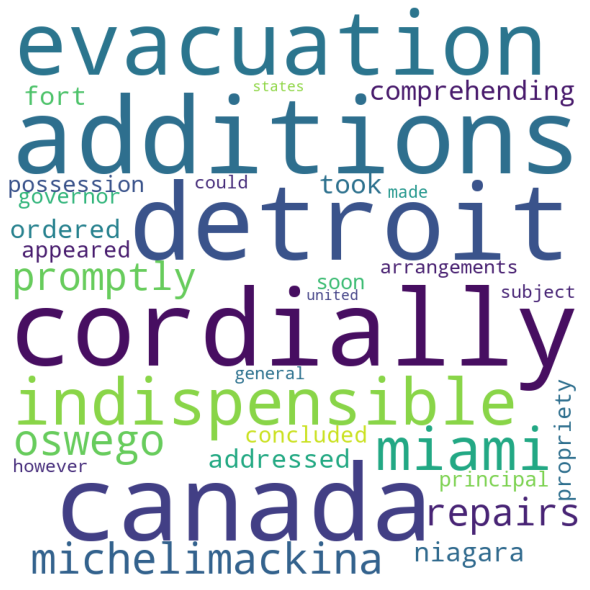

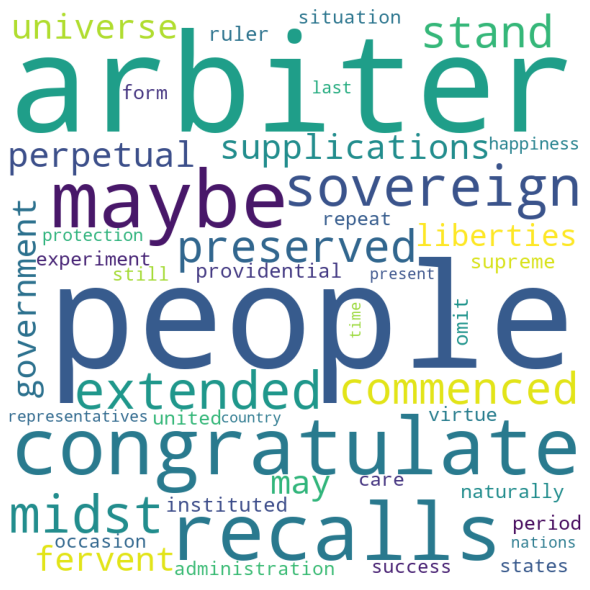

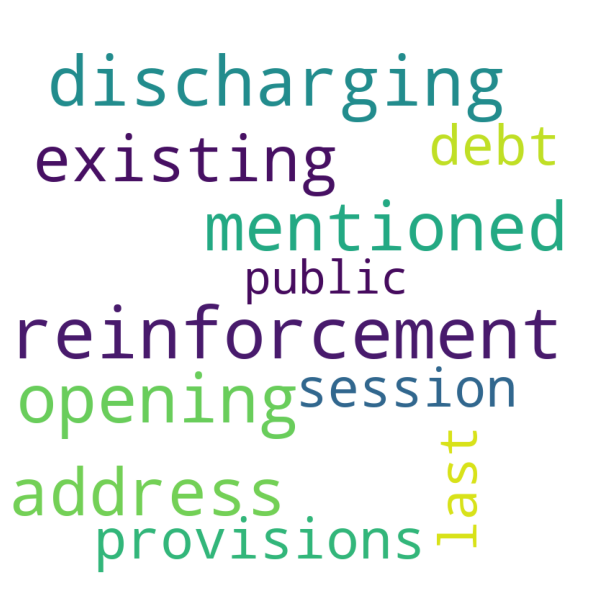

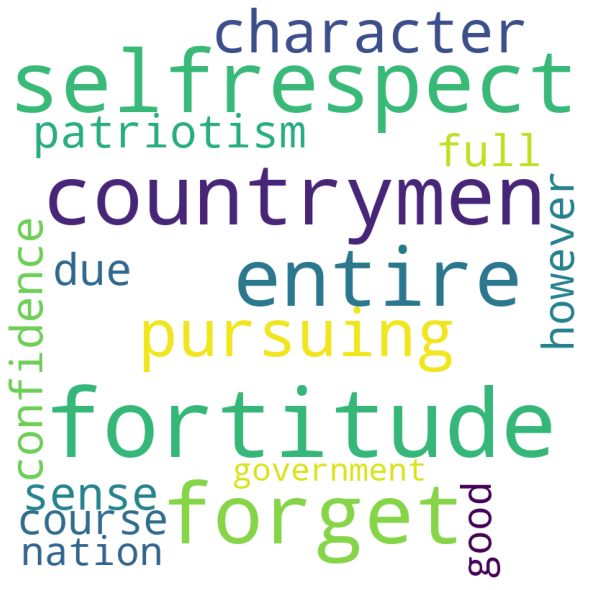

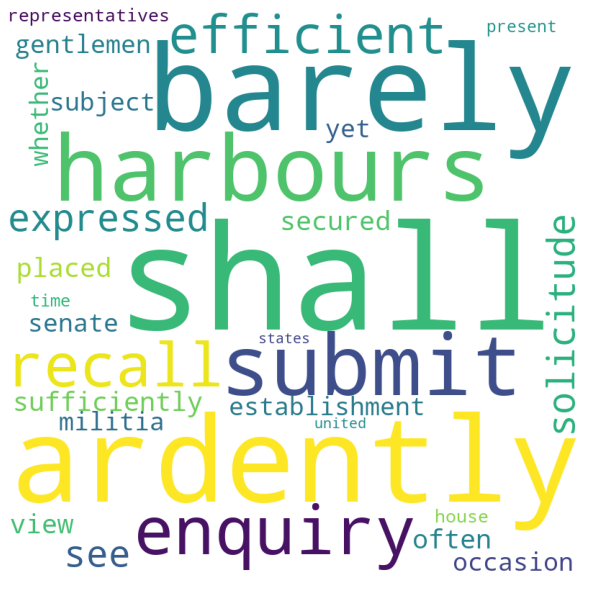

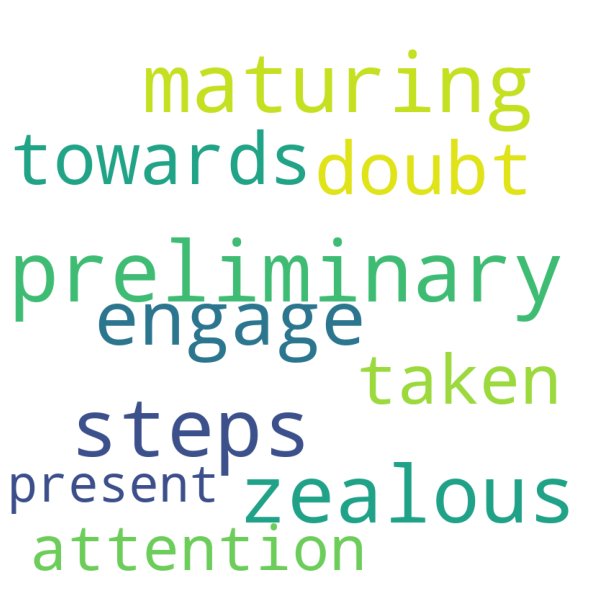

In [23]:

#Method using tfidf to output wordclouds - Unlikely to use
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Assume that you have a list of sentences stored in `sentences`

# Convert the sentences into a TF-IDF matrix
vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(filteredTranscript)

# Get the words from the TF-IDF matrix
words = vectorizer.get_feature_names_out()

# Assume that you have a numpy array `labels` of shape (number_of_sentences,), containing the cluster assignment for each sentence

# Create a list to store the word weights for each cluster
cluster_word_weights = [[] for _ in range(10)]

# For each sentence, calculate the TF-IDF weight for each word and add it to the appropriate cluster
for i, label in enumerate(labels):
    for j, word in enumerate(words):
        cluster_word_weights[label].append((word, tfidf_matrix[i, j]))

# Create a wordcloud for each cluster
for i in range(10):
    # Get the word weights for the current cluster
    word_weights = dict(cluster_word_weights[i])

    # Generate a wordcloud using the word weights
    wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10)
    wordcloud.generate_from_frequencies(word_weights)

    # Plot the wordcloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.show()





In [57]:
def color_func(word=None, font_size=None,
                     position=None, orientation=None,
                     font_path=None, random_state=None):
    colors = [[4, 77, 82],
              [25, 74, 85],
              [82, 43, 84],
              [158, 48, 79]]
    rand = random_state.randint(0, len(colors) - 1)
    return "hsl({}, {}%, {}%)".format(colors[rand][0], colors[rand][1], colors[rand][2])

['16th', '17th', 'abusing', 'accepting', 'acquiesce', 'admittance', 'affect', 'amounting', 'appearing', 'assaulting', 'avowing', 'circuitous', 'circulating', 'comply', 'cruel', 'david', 'defeat', 'detaining', 'disappointed', 'disguised', 'enacted', 'existed', 'fly', 'gaining', 'hardy', 'highways', 'humiliating', 'hundreds', 'injuring', 'insomuch', 'intention', 'intercepting', 'languish', 'lenox', 'levying', 'lowering', 'marshals', 'menaces', 'mystrenuous', 'neville', 'night', 'oblige', 'ofcandor', 'overt', 'proceeded', 'punishments', 'rounded', 'route', 'subversive', 'suggestion']


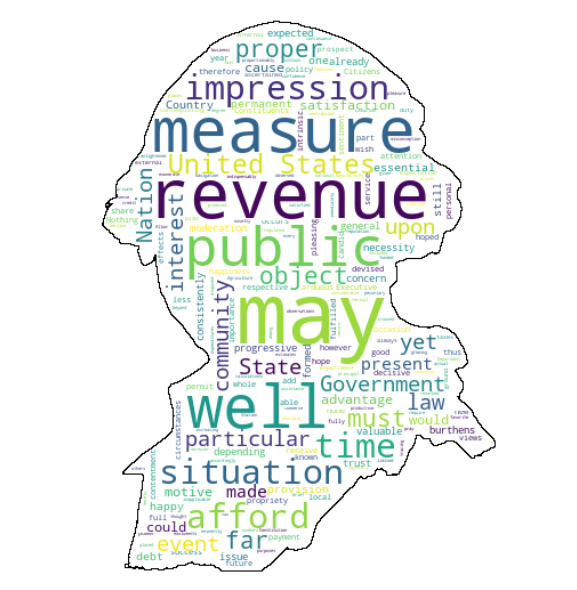

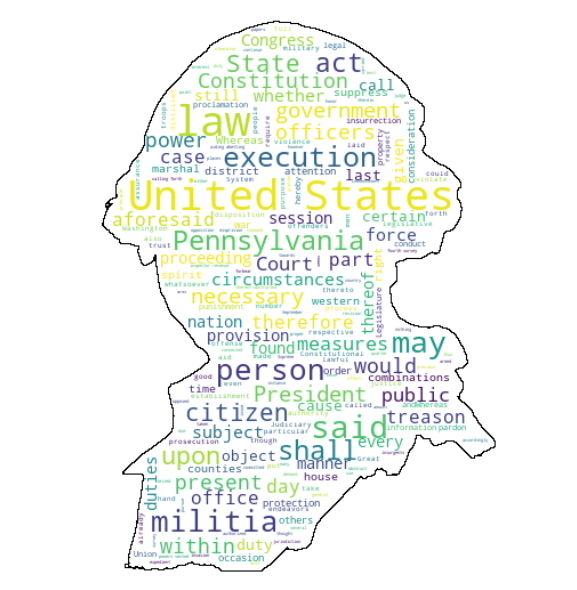

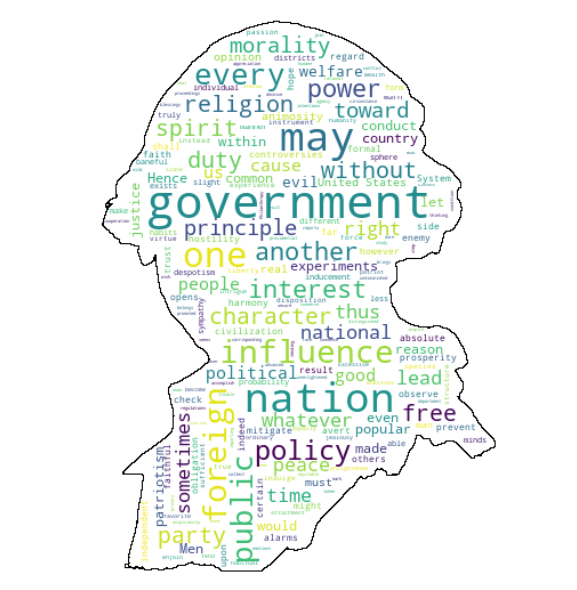

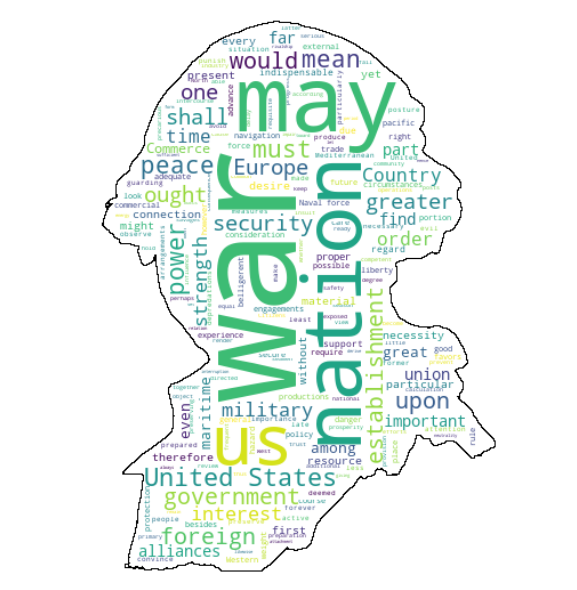

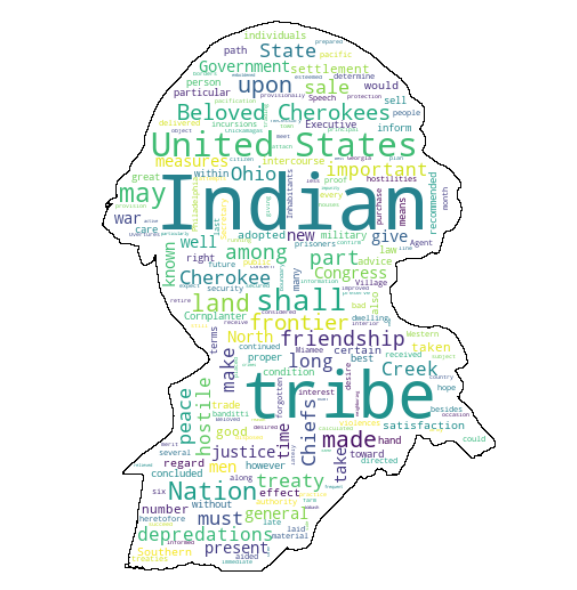

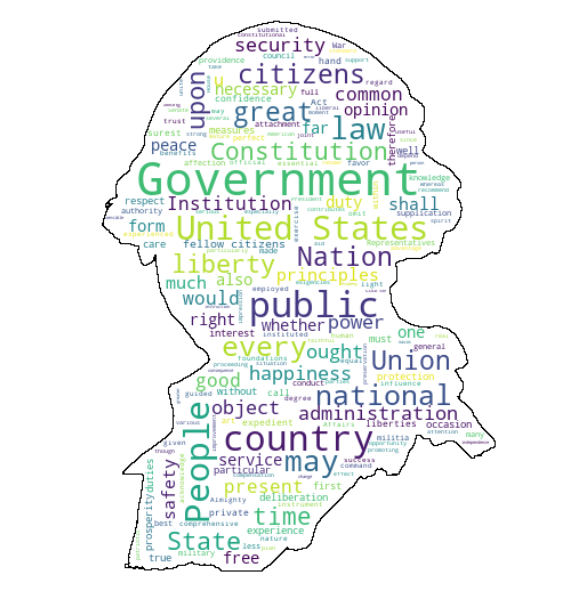

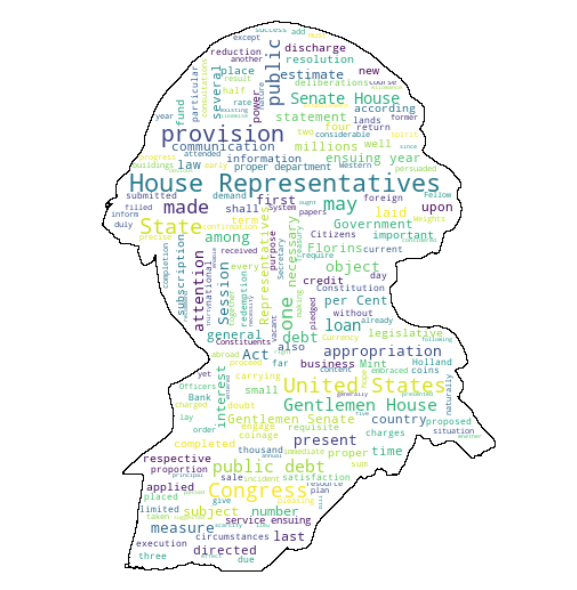

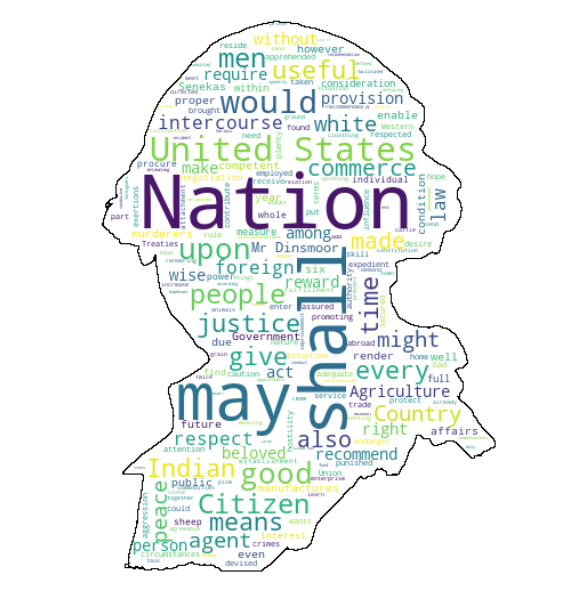

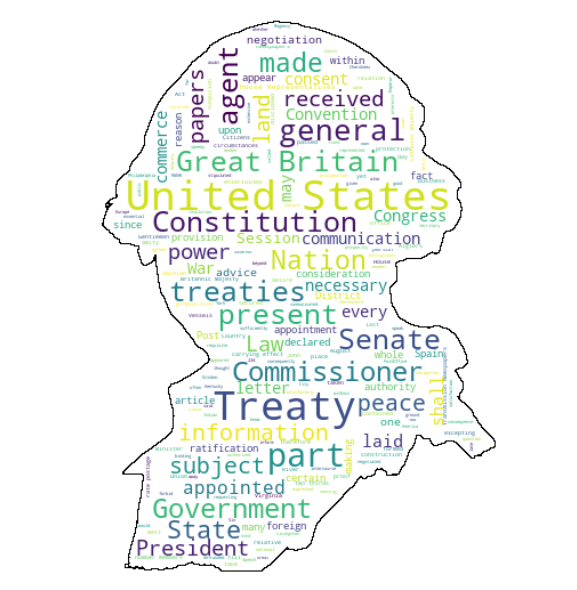

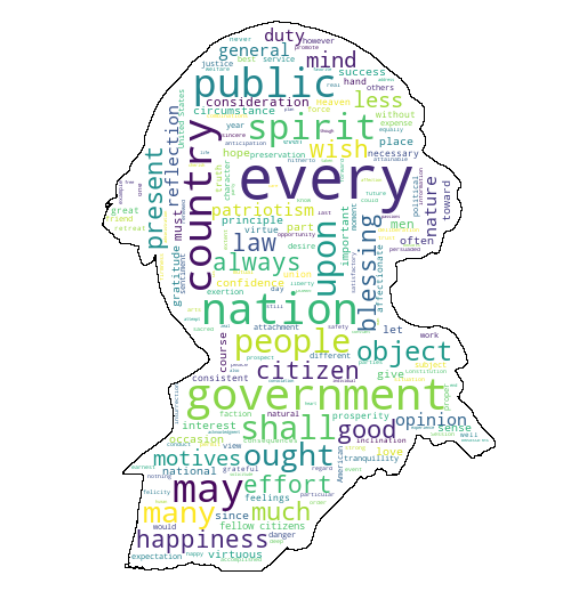

In [62]:
#Original method - probably using this
from PIL import Image
from sklearn.feature_extraction.text import TfidfVectorizer

# Your list of tokenized sentences

tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(filteredTranscript)

# Get the words and their tf-idf scores
feature_names = tfidf_vectorizer.get_feature_names_out()
scores = tfidf_matrix.toarray().mean(axis=0)

# Sort the words by their tf-idf scores
sorted_words = sorted(zip(feature_names, scores), key=lambda x: x[1])

# Print the 50 words with the lowest tf-idf scores
# print("50 words with the lowest tf-idf scores:")
# print(sorted_words[:50])
lowest_tfidf_words = []
for word, score in sorted_words[:50]:
    lowest_tfidf_words.append(word)
#     print(f"{word}: {score:.4f}")
print(lowest_tfidf_words)

#print(len(filteredTranscript))
#low_tfidf = lowest_tfidf_words(filteredTranscript)
#print(len(lowest_tfidf_words(filteredTranscript)))
mask = np.array(Image.open('gw.png'))

for i in range(kmeans.n_clusters):
    # Get the indices of sentences belonging to the current cluster
    cluster_indices = np.where(labels == i)[0]
    cluster_sentences = [filteredTranscript[index] for index in cluster_indices]

    # Combine the sentences into a single string
    cluster_text = " ".join(cluster_sentences)
    cluster_text =" ".join([ word for word in cluster_text.split() if word.lower() not in lowest_tfidf_words])
    # Generate a word cloud from the cluster text


    wordcloud = WordCloud(min_font_size=4, 
                          mask=mask,
                          width=mask.shape[1],
                          height=mask.shape[0],
                          stopwords=lowest_tfidf_words, 
                          background_color="white",
                          contour_width=1,
                          contour_color="black")
    wordcloud.generate(cluster_text)

    # Plot the word cloud
    plt.figure(figsize=(8, 8), facecolor=None)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.tight_layout(pad=0)

    plt.show()

In [ ]:
# PrePCA Cosine Similarity Matrix
heatmap = np.zeros(shape=(len(embeddings), len(embeddings)))
for i in range(len(embeddings)):
    sent = embeddings[i]
    for j in range(len(embeddings)):
        sent2 = embeddings[j]
        cosSim = cos_similarity(sent, sent2)
        heatmap[i,j] = cosSim

In [ ]:
# PostPCA Cosine Similarity Matrix (Sentence Similarity Matrix)
heatmapPost = np.zeros(shape=(len(reduced_embedding), len(reduced_embedding)))
for i in range(len(reduced_embedding)):
    sentPost = reduced_embedding[i]
    for j in range(len(reduced_embedding)):
        sent2Post = reduced_embedding[j]
        cosSimPost = cos_similarity(sentPost, sent2Post)
        heatmapPost[i,j] = cosSimPost

[[1.    0.382 0.445 ... 0.284 0.194 0.26 ]
 [0.382 1.    0.519 ... 0.33  0.208 0.306]
 [0.445 0.519 1.    ... 0.406 0.348 0.261]
 ...
 [0.284 0.33  0.406 ... 1.    0.234 0.334]
 [0.194 0.208 0.348 ... 0.234 1.    0.207]
 [0.26  0.306 0.261 ... 0.334 0.207 1.   ]]
done with PrePCA heatmap


In [ ]:
# Prenormalized Heatmaps

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCA[i,j] = heatmap[i,j]
data = heatmapPrePCA
plt.imshow( data , cmap = 'inferno' , vmax = .7, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCA = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCA[i,j] = heatmapPost[i,j]
data = heatmapPostPCA
plt.imshow( data , cmap = 'inferno' , vmax = .35, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Standardize the Data

from sklearn.preprocessing import StandardScaler
heatmapStandard = StandardScaler().fit_transform(heatmap)
heatmapPostStandard = StandardScaler().fit_transform(heatmapPost)

# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCAStandard[i,j] = heatmapStandard[i,j]
data = heatmapPrePCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCAStandard = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCAStandard[i,j] = heatmapPostStandard[i,j]
data = heatmapPostPCAStandard
plt.imshow( data , cmap = 'inferno' , vmax = 3, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Heatmap" )
plt.show()

In [ ]:
# Normalized Heatmaps

# Normalize Pre and Post Cosine Similarity Matrixs
heatmapmax, heatmapmin = heatmap.max(), heatmap.min()
heatmapPreNorm = (heatmap - heatmapmin)/(heatmapmax - heatmapmin)
heatmapPostmax, heatmapPostmin = heatmapPost.max(), heatmapPost.min()
heatmapPostNorm = (heatmapPost - heatmapPostmin)/(heatmapPostmax - heatmapPostmin)
# PrePCA Heatmap
x = 100
y = 100
heatmapPrePCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPrePCANorm[i,j] = heatmapPreNorm[i,j]
data = heatmapPrePCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.6, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PrePCA Normalized Heatmap" )
plt.show()

# PostPCA Heatmap
x = 100
y = 100
heatmapPostPCANorm = np.zeros(shape=(y, x))
for i in range(y):
  for j in range(x):
    heatmapPostPCANorm[i,j] = heatmapPostNorm[i,j]
data = heatmapPostPCANorm
plt.imshow( data , cmap = 'inferno' , vmax = 0.5, interpolation = 'nearest' )
# color schemes that work well (cmap =): cividis, viridis, inferno. Full list: https://matplotlib.org/stable/tutorials/colors/colormaps.html
plt.title( "Transcript 0: PostPCA Normalized Heatmap" )
plt.show()

In [ ]:
# Test Code

fullTranscripts = pd.DataFrame(fullTranscripts)
fullTranscripts.to_csv('fullTranscripts.csv')

embedding = pd.DataFrame(embedding)
embedding.to_csv('embedding.csv')

reduced_embedding = pd.DataFrame(reduced_embedding)
reduced_embedding.to_csv('reduced_embedding.csv')